# Filtering, integrate and equation equivalence
This is to show that the on-line training and off-line learning are the same

In [68]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

In [71]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#### Create the signal

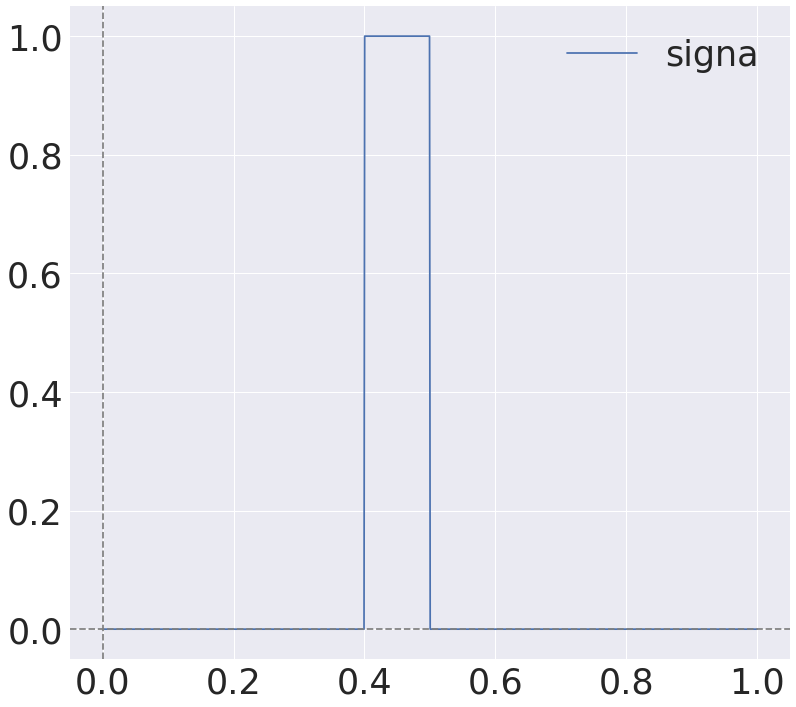

In [10]:
T = 1.0
dt = 0.001
Tp = 0.100
T1 = 0.400

nt = int(T / dt)
ns = int(T1 / dt)
n_dur = int(Tp / dt)
ne = ns + n_dur

time = np.linspace(0.0, T, num=nt)
s = np.zeros(nt)
s[ns:ne] = 1.0

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, s, label='signa')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

#### Filter the signal with a differential equation

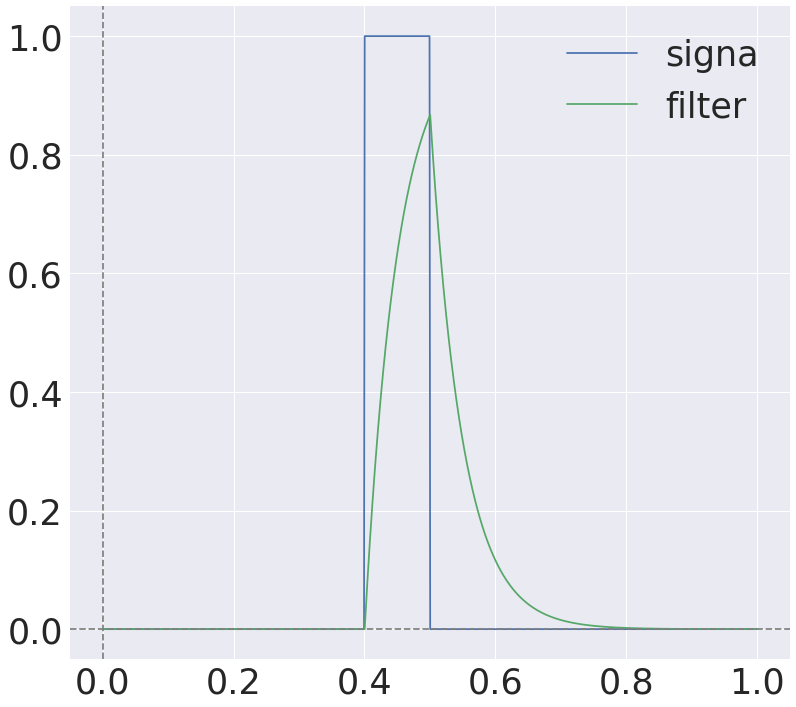

In [11]:
tau_z = 0.050
z = np.zeros(nt)
z[0] = 0

for index in range(nt - 1):
    z[index + 1] = z[index] + (dt / tau_z) * (s[index] - z[index])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, s, label='signal')
ax.plot(time, z, label='filter')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

#### Build the filter

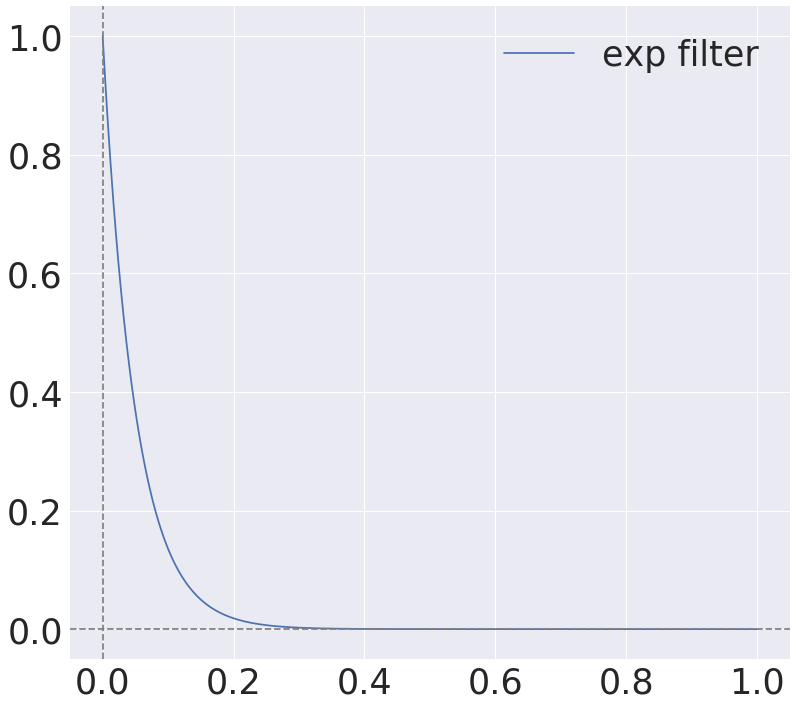

In [13]:
exp_filter = np.exp(-time / tau_z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, exp_filter, label='exp filter')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

#### Plot the filter for different modes

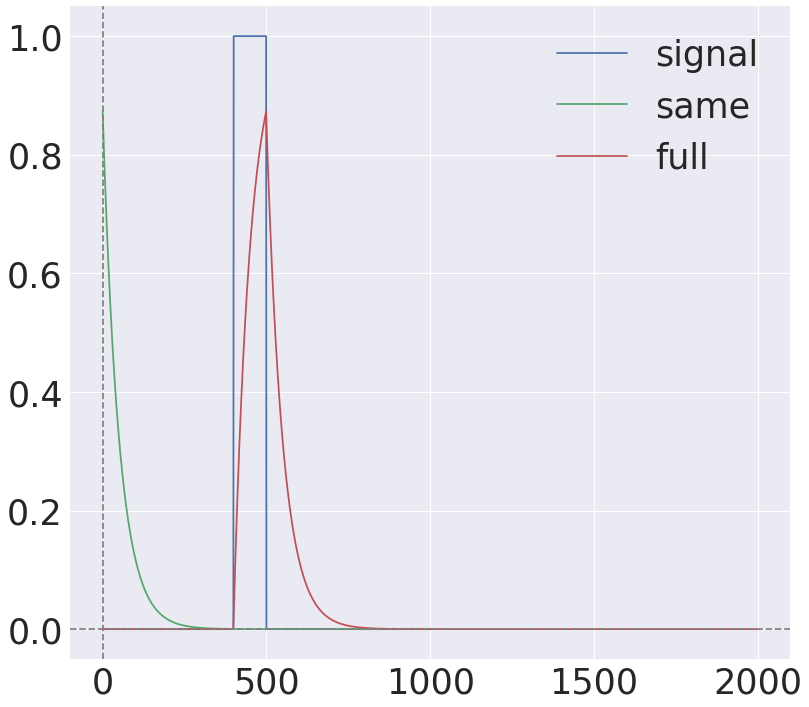

In [27]:
normalizing = dt / tau_z
z1 = np.convolve(s, exp_filter, mode='same') * normalizing
z2 = np.convolve(s, exp_filter, mode='full') * normalizing

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(s, label='signal')
ax.plot(z1, label='same')
ax.plot(z2, label='full')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

In [29]:
z3 = np.convolve(s, exp_filter, mode='valid') * normalizing
print('same shape', z1.shape)
print('full shape', z2.shape)
print('valid shape', z3.shape)
print('signal shape', s.shape)

same shape (1000,)
full shape (1999,)
valid shape (1,)
signal shape (1000,)


* Full: it seems that full takes care of the proper alignment, but produces a tail that we have to get rid off. 
* Same: Same on the other hand gets the number of points right but is misaligned.
* Valid is just one point, because just for one point the signals overlap fully. 

Note that we used a normalizing factor (dt / tau_z)

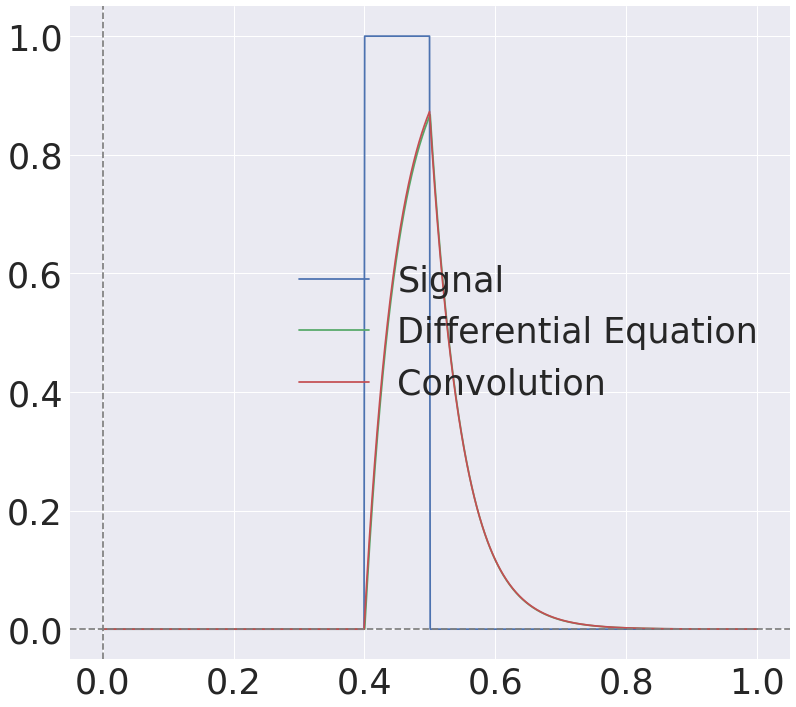

In [30]:
z_filtered = z2[:nt]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, s, label='Signal')
ax.plot(time, z, label='Differential Equation')
ax.plot(time, z_filtered, label='Convolution')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

## Functions 

In [42]:
def ODE_filter(signal, dt, tau_z):
    nt = signal.shape[0]
    z = np.zeros(nt)
    z[0] = 0

    for index in range(nt - 1):
        z[index + 1] = z[index] + (dt / tau_z) * (signal[index] - z[index])
        
    return z

def Integral_filter(signal, time, dt, tau_z):
    nt = signal.shape[0]
    exp_filter = np.exp(-time / tau_z)
    normalizing = dt / tau_z
    z = np.convolve(s, exp_filter, mode='full') * normalizing
    
    return z[:nt]

def create_signal(T, dt, Tp, T1):
    nt = int(T / dt)
    ns = int(T1 / dt)
    n_dur = int(Tp / dt)
    ne = ns + n_dur

    time = np.linspace(0.0, T, num=nt)
    signal = np.zeros(nt)
    signal[ns:ne] = 1.0
    
    return signal, time

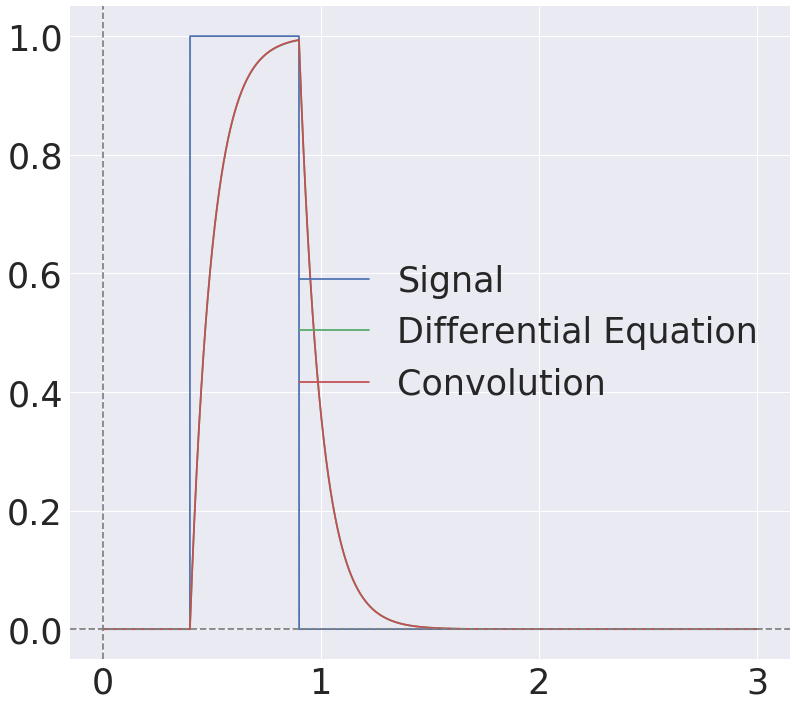

In [100]:
T = 3.0
dt = 0.0001
Tp = 0.500
T1 = 0.400
tau_z = 0.100

s, time = create_signal(T, dt, Tp, T1)
z_ode = ODE_filter(s, dt, tau_z)
z_int = Integral_filter(s, time, dt, tau_z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time, s, label='Signal')
ax.plot(time, z_ode, label='Differential Equation')
ax.plot(time, z_int, label='Convolution')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

## Systematic
We have to test both T_p, T_total, and tau_z which I supsect are the most important. Maybe dt?

In [81]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(1.0, 10.0, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


dt = 0.001
Tp = 0.500
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, T in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.mean(z_ode - z_int)

CPU times: user 1min 7s, sys: 296 ms, total: 1min 7s
Wall time: 35.2 s


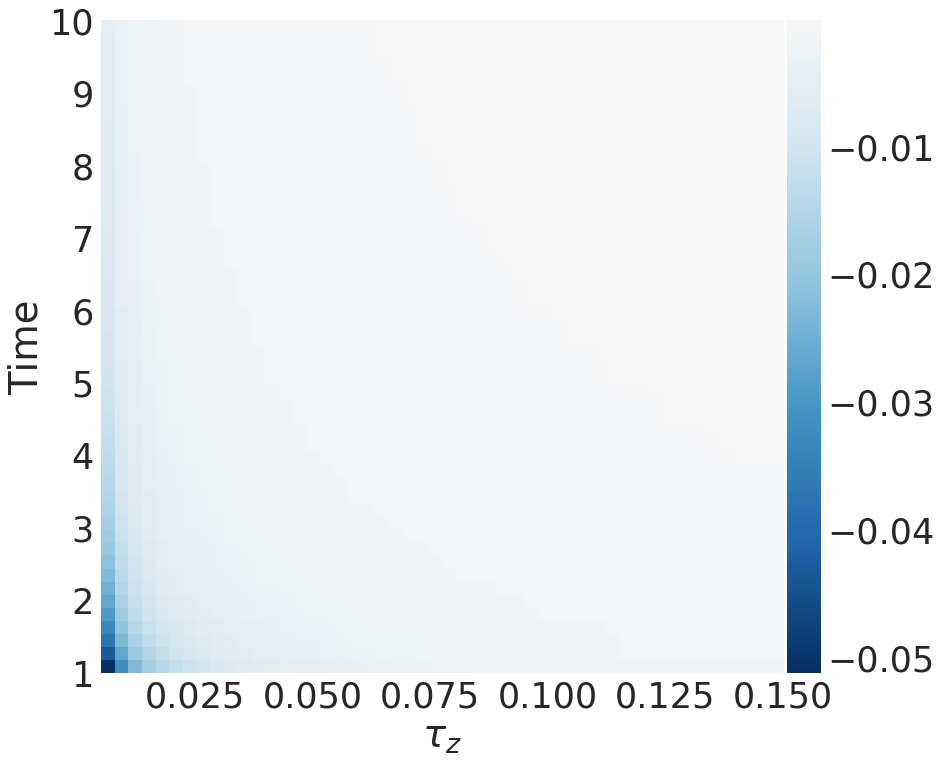

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('Time')
ax.grid();

#### Compare Tp, and tau_z

In [83]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(0.100, 1.0, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


T = 3.0
dt = 0.001
Tp = 0.500
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, Tp in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.mean(z_ode - z_int)

CPU times: user 9.82 s, sys: 4 ms, total: 9.83 s
Wall time: 9.83 s


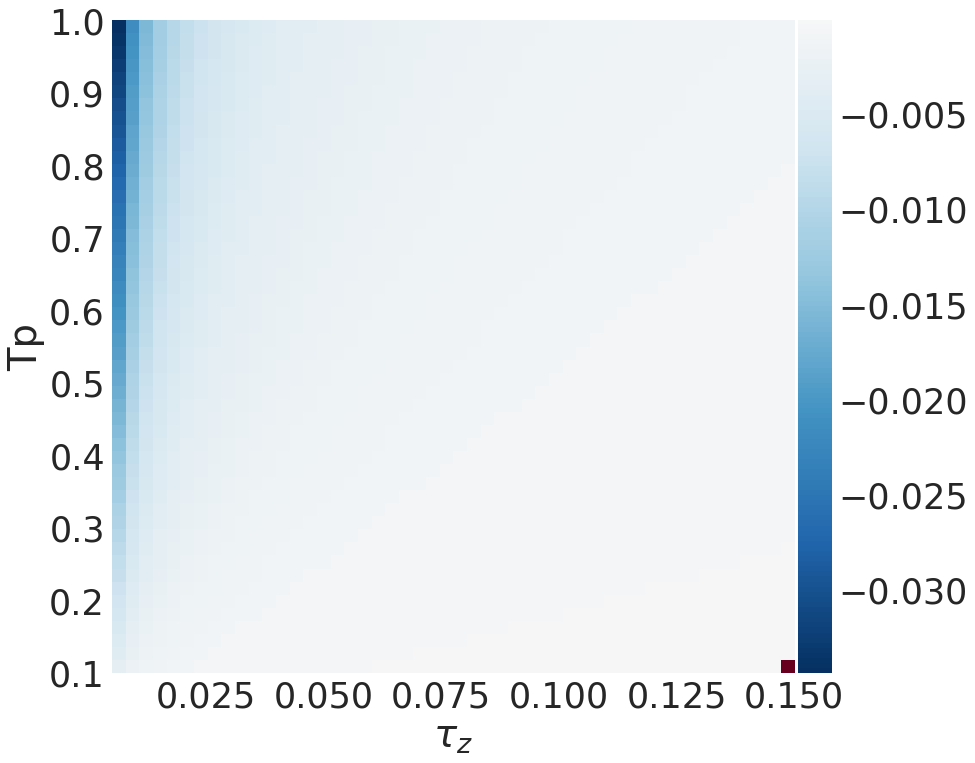

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('Tp')
ax.grid();

#### Compare T1 (start time)

In [85]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(0.100, 1.900, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


T = 2.0
dt = 0.001
Tp = 0.100
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, T1 in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.mean(z_ode - z_int)

CPU times: user 5.78 s, sys: 0 ns, total: 5.78 s
Wall time: 5.78 s


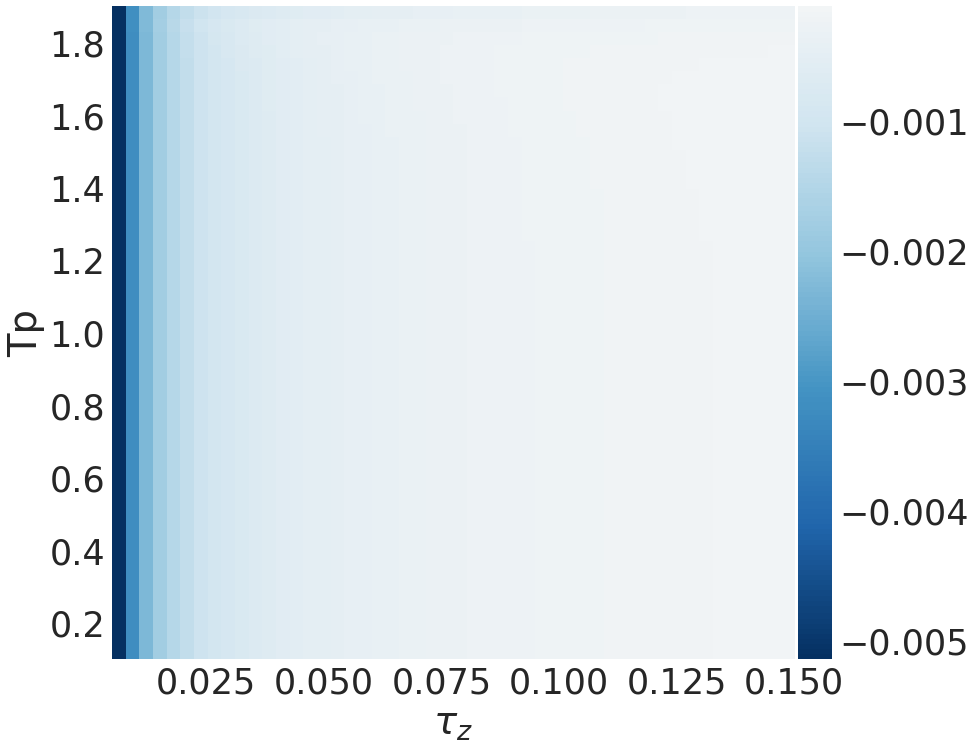

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('T1')
ax.grid();

## Compare norms instead of mean distance

In [87]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(1.0, 10.0, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


dt = 0.001
Tp = 0.500
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, T in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.linalg.norm(z_ode - z_int)

CPU times: user 1min 10s, sys: 308 ms, total: 1min 11s
Wall time: 37.2 s


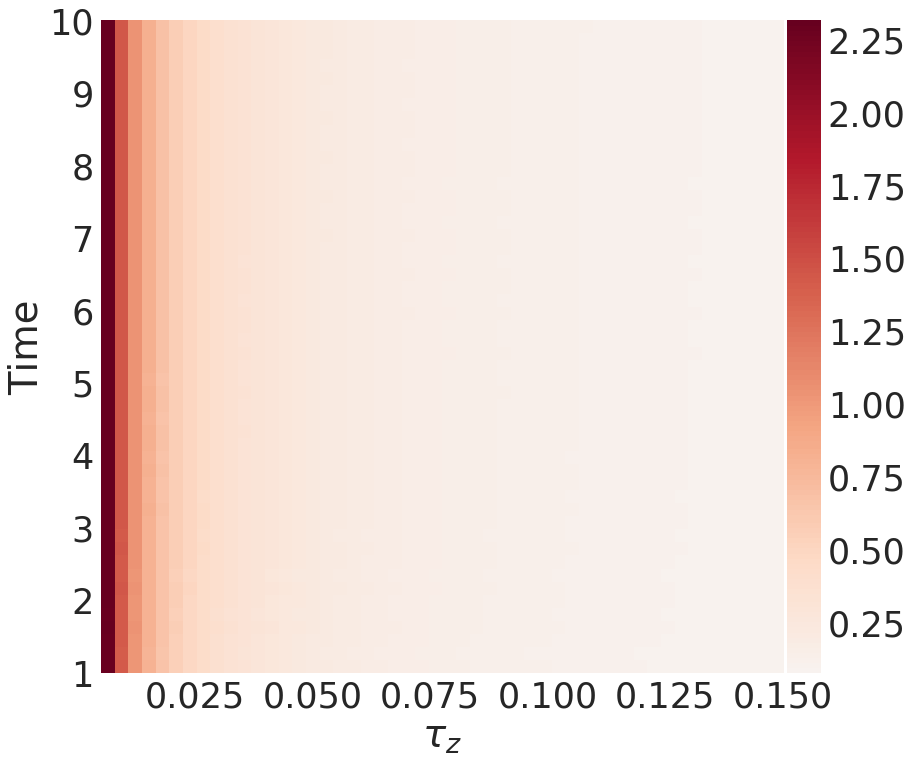

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('Time')
ax.grid();

#### Tp and tau_z

In [93]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(0.100, 1.0, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


T = 3.0
dt = 0.001
Tp = 0.500
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, Tp in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.linalg.norm(z_ode - z_int)

CPU times: user 11.2 s, sys: 44 ms, total: 11.2 s
Wall time: 11.2 s


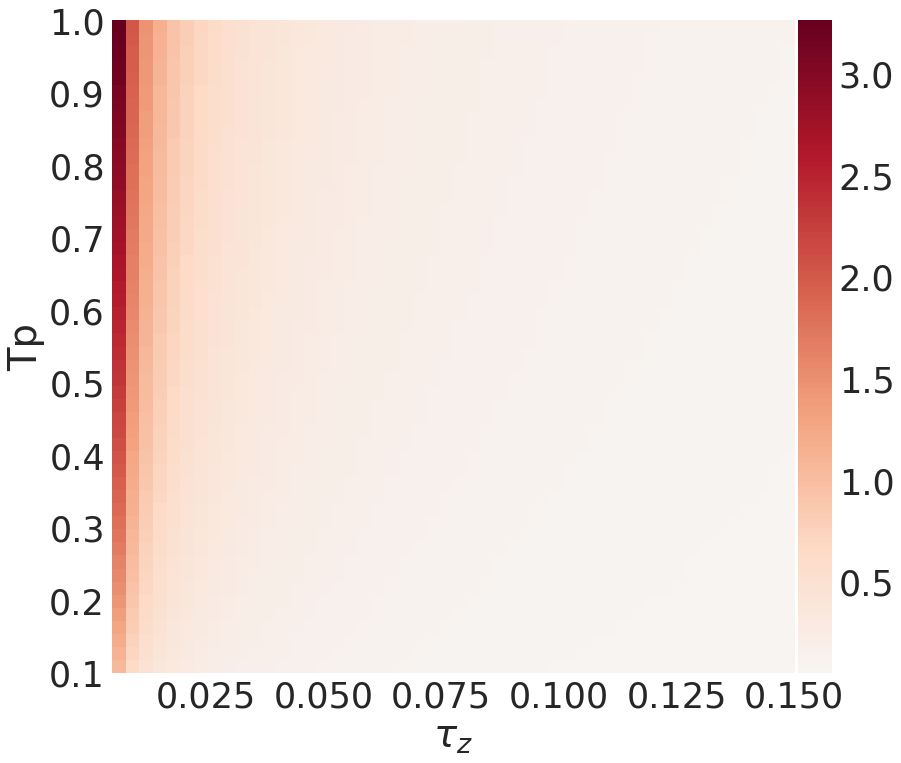

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('Tp')
ax.grid();

#### T1 (start time)

In [95]:
%%time

num1 = 50
num2 = 50
times_collection = np.linspace(0.100, 1.900, num=num1)
tau_z_collection = np.linspace(0.005, 0.150, num=num2)


T = 2.0
dt = 0.001
Tp = 0.100
T1 = 0.400
tau_z = 0.100

distances = np.zeros((num1, num2))

for index1, T1 in enumerate(times_collection):
    for index2 , tau_z in enumerate(tau_z_collection):
        
        s, time = create_signal(T, dt, Tp, T1)
        z_ode = ODE_filter(s, dt, tau_z)
        z_int = Integral_filter(s, time, dt, tau_z)
        
        distances[index1, index2] = np.linalg.norm(z_ode - z_int)

CPU times: user 4.72 s, sys: 0 ns, total: 4.72 s
Wall time: 4.73 s


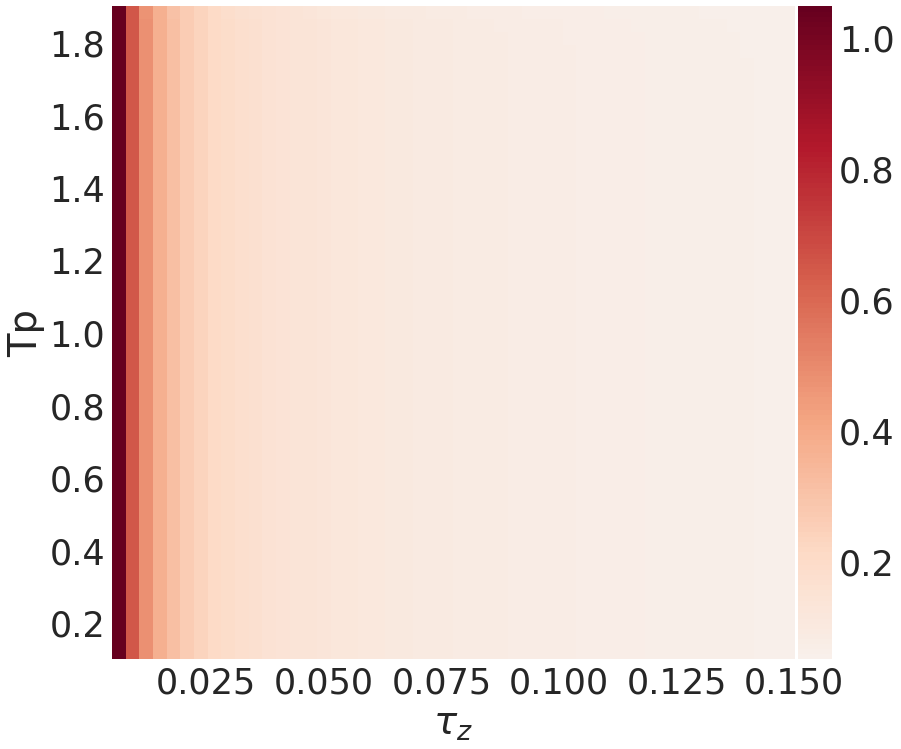

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111)

cmap = matplotlib.cm.RdBu_r
norm = MidpointNormalize(midpoint=0)
extent = [tau_z_collection[0], tau_z_collection[-1], times_collection[0], times_collection[-1]]
im = ax.imshow(distances, norm=norm, origin='lower', cmap=cmap, extent=extent, aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel(r'$\tau_z$')
ax.set_ylabel('T1')
ax.grid();